## Restructuring Bandits and Agents

What happens if your agent is trying different strategies/policies? To compare do this, I am encapsulating agents under a general class pattern here, where each can have a different form for choosing the next lever to pull.

This is exactly the same as before, just being careful to make sure the access to each of the different agents is the same.

This notebook exists to test out functionality of the different kinds of agents.

First, quickly define a very simple bandit, where the expectation value of the reward for each arm, and the best reward return possible are available as attributes (this is to enable us to calculate the Regret).

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
#basic bandit to test the functionality of agents
class Bandit:
    """Class for a simple k-armed bandit without context dependence.
    It includes variable number of arms, initialization reward distribution for
    each arm (hidden from agent) and method to have arm pulled and return reward. """

    def __init__(self, k):
        self.k = k
        self.means = np.random.normal(loc=0, scale=2, size=k) #this is expectation value in this case for each level
        #just to make it explicit:
        self.expected_reward = self.means
        self.stdevs = [1] * k

        self.best_arm = np.argmax(self.means)
        self.best_reward = self.means[self.best_arm]

    def pull_lever(self, lever):
        return np.random.normal(loc=self.means[lever], scale=self.stdevs[lever])


Here I am trying to trim down the fat of the GreedyAgent class used for the toy example, and making it more general. I am reformulating the outputs in terms of regret, as well as the q(s,a). q(s,a) is an updating table of what the expected reward of a particular action is, wheras regret is the difference between that and the ideal case. It is helpful to have access to both. 

Each agent requires the ability to take an action, one at a time, and receive an updated estimate of the action-value function corresponding to that action. I have also included the possibility of updating the regret. 

In [46]:
class eGreedyAgent:
    
    def __init__(self, bandit):
        #only require the bandit to initialise
        
        #general attributes of all agents
        self.bandit = bandit
        self.pull_record = [0] * self.bandit.k
        
        #required to keep track of the agent's knowledge of the probability distributions
        # (actually some are redundant, but useful!)
        self.Q = [0] * self.bandit.k
        #cumulative regret
        self.regret = [0] * self.bandit.k
        #keeping an eye on how regret changes (how well it converges)
        self.regrets_trajectory = [] 
        
    def act(self):
        #the difference here is that the choice of lever is included directly with call to another function
        #and excess monitoring is removed. 
        
        #choose the lever e-greedily
        explore = np.random.rand()
        if explore <= self.epsilon:
            lever = np.random.choice(self.bandit.k)
        else:
            lever = np.argmax(self.Q)

        # Update the array keeping track of how many times each lever has been pulled
        self.pull_record[lever] += 1
        
        #actually get back the reward
        reward = self.bandit.pull_lever(lever)

        # update the q estimate
        self.update_Q(lever, reward)
        
    def update_Q(self, lever, reward):
        self.Q[lever] = self.Q[lever] + (1 / self.n[lever]) * (reward - self.Q[lever])
        
    def update_R(self, reward, lever):
        
        self.regret[lever] += (self.bandit.best_reward - self.reward[lever])
        self.regrets_trajectory.append(self.regret)
        
        
        

This is all very well but it doesn't yet generalise to not just e-greedy action rules. In a high-level abstraction way, what does a general agent need to do? i.e. assuming the action is taken care of in child classes. 

* making choice of lever pulling, pulling it and recording what happens -- child class
* recording the update to the Q and R -- parent class

From dividing tasks up in this way (and it isn't unique) it is clear that the thing that all the child classes need to have in common is the ability to pass back/produce in a uniform way it's latest idea of the Q value and Regret for all levers. This actually amounts to the child class being able to return, based on the reward it finds, the updated Q value, as Regret is derived from that. 

Given access to updated Q, the parent can 'deal' with regret tracking.

Perhaps a better way of thinking about this kind of abstraction is just that the child class is cut down to provide the smallest possible varying unit of functionality -- the trick is just to figure out where exactly the boundary lies. 


With this in mind, let's define a parent class and e-greedy child class. 

(I actually put a whole load of extra functionality back in here compared to above, because I want to be able to diagnose whether my system is working correctly. There is a broader point -- these systems are really hard to debug!)

In [216]:
class StandardAgent:
    
    def __init__(self, bandit):
        #only require the bandit to initialise
        
        #general attributes of all agents
        self.bandit = bandit
        self.pull_record = [0] * self.bandit.k
        self.action_sequence = []
        
        #for keeping track of how the agent learns
        self.num_optimal_pulls = 0
        self.optimal_trajectory = []
        
        #keep track of the agent's knowledge of the probability distributions
        #cumulative regret
        self.total_regret = 0
        #keeping an eye on how regret changes
        self.regrets_trajectory = []
        
    def update_R(self, lever):
        
        self.total_regret += (self.bandit.best_reward - self.bandit.expected_reward[lever])
        self.regrets_trajectory.append(self.total_regret)
        
    def choose_lever(self):
        #in child classes this involves getting back the lever and returning the reward
        raise NotImplementedError('Not a method in this parent class.')
        
    @property
    def Q_values(self):
        raise NotImplementedError('Not a method in this parent class.')
        
    def run_trial(self, n_steps):
        for step in range(n_steps):
            lever = self.choose_lever()
            
            # Update the array keeping track of how many times each lever has been pulled
            self.pull_record[lever] += 1
            
            # update whether lever was best
            if lever == self.bandit.best_arm:
                self.num_optimal_pulls += 1
            self.optimal_trajectory.append(self.num_optimal_pulls / np.sum(self.pull_record))
            
            self.action_sequence.append(lever)
            # update the regret 
            self.update_R(lever)
    

In [219]:
class eGreedyAgent(StandardAgent):
    
    def __init__(self, bandit, epsilon = 0.1):
        super(eGreedyAgent, self).__init__(bandit)
        
        self.epsilon = epsilon
        
        self.estimatedQ = [0]*self.bandit.k #initialise as zero
        self.Q_trajectory = []
        
        self.reward = 0
        
    def choose_lever(self):
        
        #choose the lever e-greedily
        explore = np.random.rand()
        if explore <= self.epsilon:
            lever = np.random.choice(self.bandit.k)
        else:
            lever = np.argmax(self.Q_values)
            
        #get the reward from the bandit that corresponds to this
        self.reward = self.bandit.pull_lever(lever)
        
        self.estimatedQ[lever] += (1 / (self.pull_record[lever]+1)) * (self.reward - self.estimatedQ[lever])
        
        #self.Q_values = Q_values(reward, lever)
        self.Q_trajectory.append(self.estimatedQ)
        
        return lever
    
    @property
    def Q_values(self):
        #print('getting Q_values')
        return self.estimatedQ


Really basic demonstration of getter and setter property decorators from somewhere on stackoverflow. A lot of the time people are only using getters. 

In [203]:
class DumbClass():
    def __init__(self, p):
        self._ciao = p

    @property
    def ciao(self):
        return self._ciao

    @ciao.setter
    def ciao(self, v):
        self._ciao = v

## Slight aside about use of @property decorator

Which I am only using here to get access to something from a class in a consistent way, and I will extend the functionality.

In [204]:
greeting = DumbClass('Hey!')
print(DumbClass.ciao)
print(greeting.ciao)
greeting.ciao = 'See you!'
print(DumbClass.ciao)
print(greeting.ciao)

Hey!
See you!


Which also nicely illustrates the difference between Classes and their instances: the class is a fixed thing in memory. The instance actually has now a dictionary of attributes. See https://www.programiz.com/python-programming/property

In [205]:
greeting.__dict__

{'_ciao': 'See you!'}

## Testing out the functionality of the classes

This basic check shows that everything is working how it did before with the really simple implementations.

In [220]:
bandit = Bandit(10)
b = eGreedyAgent(bandit)

In [228]:
b.run_trial(10000)

In [229]:
b.estimatedQ

[-1.9887590366942747,
 0.7064472410407363,
 -0.197788369071265,
 0.5050038541502088,
 -0.9298835274420434,
 -2.6515210411317756,
 2.7050110276673047,
 0.5329245072533784,
 -1.3143650773586382,
 1.4168845564237715]

In [230]:
b.Q_values #yay! A working example of a property being used to set up a getter!

[-1.9887590366942747,
 0.7064472410407363,
 -0.197788369071265,
 0.5050038541502088,
 -0.9298835274420434,
 -2.6515210411317756,
 2.7050110276673047,
 0.5329245072533784,
 -1.3143650773586382,
 1.4168845564237715]

In [231]:
b.pull_record

[114, 108, 98, 104, 114, 88, 10031, 108, 115, 120]

In [232]:
b.bandit.best_arm

6

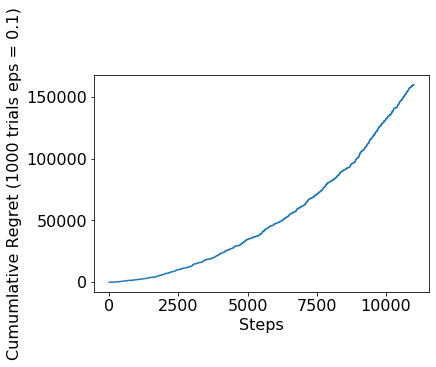

In [233]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(b.regrets_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('Cumumlative Regret (1000 trials eps = 0.1)', fontsize=16)
plt.show()

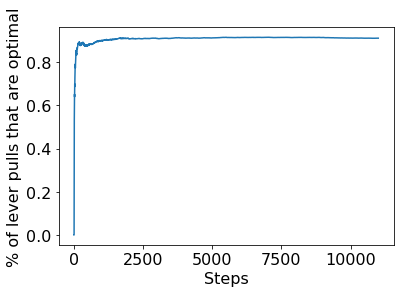

In [234]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(b.optimal_trajectory)
ax.tick_params(labelsize=16)
ax.set_xlabel('Steps', fontsize=16)
ax.set_ylabel('% of lever pulls that are optimal', fontsize=16)
plt.show()

In [237]:
b.action_sequence

[0,
 1,
 2,
 2,
 3,
 4,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 0,
 6,
 6,
 6,
 2,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 2,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 0,
 6,
 6,
 6,
 8,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 6,
 6,
 6,
 4,
 6,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 2,
 6,
 6,
 3,
 8,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 9,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
